In [1]:
!pip install -Uqq fastai duckduckgo_search


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflo

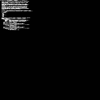

In [2]:
import PIL
IMG_WIDTH = 250

def char_to_pixel(c):
    if c == ' ':
        return 1
    return min(255, ord(c) * 2 - 1)

def textlines_to_image(lines, img_file, width=IMG_WIDTH):
    lines_processed = 0
    raw = []
    for line in lines:
        padded_line = line[:width].ljust(width, ' ')
        pixels = [char_to_pixel(c) for c in padded_line]
        raw.extend(pixels)
        lines_processed += 1
    blank_line = [1] * width
    while lines_processed < width:
        raw.extend(blank_line)
        lines_processed += 1
    # padded_text
    # return raw
    im = PIL.Image.frombytes('L', (width, width), bytes(raw))
    im.save(img_file, 'png')
    

# test
import inspect
import difflib
source = inspect.getsource(difflib.context_diff)
#source = inspect.getsource(inspect.getsource)
textlines_to_image(source.splitlines(), 'python.png')

from fastai.vision.all import *
Image.open('python.png').to_thumb(100, 100)

In [3]:
from fastdownload import *

python_zip_url = 'https://github.com/Shemiou/Small_Python/archive/refs/heads/master.zip'
download_url(python_zip_url, dest='python.zip', show_progress=False)

from zipfile import ZipFile


def lines_of_zipped_files(zipfile, file_filter):
    with ZipFile(zipfile) as zf:
        for file in zf.namelist():
            if file_filter(file):
                with zf.open(file) as f:
                    for line in f.readlines():
                        yield line.decode()

def filter_for_extension(extension):
    return lambda file: file.endswith(extension)

all_lines = lines_of_zipped_files('python.zip', filter_for_extension('.py'))           
[line for line in all_lines][:5]

['#!/usr/bin/env python\n',
 '# -*- coding: utf-8 -*-\n',
 '\n',
 'import sys\n',
 'import time\n']

In [4]:
def partition(iterable, chunk_size):
    items_added = 0
    chunk = []
    for item in iterable:
        items_added += 1
        chunk.append(item)
        if items_added == chunk_size:
            yield chunk
            items_added = 0
            chunk = []
    if chunk:
        yield chunk
        
test_eq([[0, 1], [2, 3], [4, 5]], [i for i in partition(range(6), 2)])
test_eq([[0, 1], [2, 3], [4]], [i for i in partition(range(5), 2)])

In [5]:
from pathlib import Path

def lines_to_images(lines, folder_path):
    folder_path.mkdir(parents=True, exist_ok=True)
    chunk_index = 0
    for chunk in partition(lines, IMG_WIDTH):
        chunk_index += 1
        file = folder_path / "{0}.png".format(chunk_index)
        textlines_to_image(chunk, file)
    
all_lines = lines_of_zipped_files('python.zip', filter_for_extension('.py'))           
some_lines = [l for l in all_lines][:2*IMG_WIDTH]
lines_to_images(some_lines, Path('tmp'))


In [6]:
def download_zip_and_convert_lines_to_images(url, dest_zip, extension, target_folder):
    download_url(url, dest_zip, show_progress=False)
    all_lines = lines_of_zipped_files(dest_zip, filter_for_extension(extension))
    lines_to_images(all_lines, Path(target_folder))

path = Path('python_or_java')
download_zip_and_convert_lines_to_images(python_zip_url, 'python.zip', '.py', path / 'python')
java_zip_url = 'https://github.com/eea15/small-java-projects/archive/refs/heads/master.zip'
download_zip_and_convert_lines_to_images(java_zip_url, 'java.zip', '.java', path / 'java')



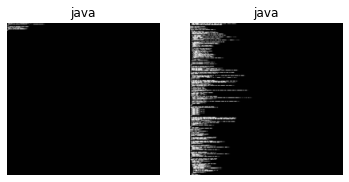

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=2)

dls.show_batch(max_n=6)